In [ ]:
from langchain_core.messages import AIMessage
from typing_extensions import TypedDict
from langgraph.graph import START, StateGraph, END
from langgraph.graph.state import CompiledStateGraph
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
api_key = os.getenv('MISTRAL_API_KEY')  # Correct variable name

from langchain_mistralai import ChatMistralAI

llm = ChatMistralAI(
    model="mistral-small",  # Correct model name
    temperature=0,
    max_retries=2,
    api_key=api_key)

class FirstLlmAgent(TypedDict):
    prompt: str
    output: str

class FeedbackAgent(TypedDict):
    user_feedback: str
    session_status: str


In [13]:
from langchain_core.prompts import PromptTemplate
def classify_query(query: str):
    prompt = """Classify this query in diffrent categories that which type of query it is
    Query: {query}
    
    response guidlines:
    1. the answer should be only a single category 
    2. you must not give a descriptive answer
    do not give answer to provided question just give its category that what kind of question it is?
    3. no need to give any explanation or description of the query
    4. just give the category of the query like: billing, technical, general, etc."""
    # Use the LLM to classify the query type
    

    prompt_template = PromptTemplate.from_template(prompt)

    chain = prompt_template | llm 

    chain_response = chain.invoke(query)
    llm_response = chain_response.content
    return llm_response

# Example usage
query="which programing language is used mostly?"
classify_query(query)

'Technical\nUser seems to be asking about the most popular programming language, which falls under the category of technology or programming.'

In [14]:

def query_classifier_agent(state: FirstLlmAgent):
    print("__QueryClassifierAgent__", state)
    prompt = state['prompt']
    query_type = classify_query(prompt) # Here you will implement the logic to classify query types (e.g., billing, technical, general)
    return {"query_type": query_type}


In [40]:
def collect_feedback(classify_response: str, prompt_response: str):
    """
    Given a prompt and its classified response, ask the LLM to judge if the classification is correct.
    If correct, explain why. If not correct, explain why not.
    """
    feedback_prompt = (
        f"Prompt: {prompt_response}\n"
        f"Classification: {classify_response}"
    )
    generated_classification = llm.invoke(feedback_prompt)
    return generated_classification.content

classify_response = 'technical'
prompt_response = 'which programming language is mostly used?'
response = collect_feedback(classify_response, prompt_response)
response


"As of 2021, JavaScript is the most commonly used programming language, according to the TIOBE Index, which ranks programming languages based on the number of skilled engineers worldwide, courses and third-party vendors. However, it's important to note that the most commonly used programming language can vary depending on the specific use case or industry. For example, Python is widely used in data science and machine learning, while Java is commonly used in enterprise-level applications. Ultimately, the choice of programming language depends on the specific requirements of the project and the expertise of the development team."

In [ ]:
def collect_feedback(classify_response: str, prompt_response: str):
    """
    Given a prompt and its classified response, ask the LLM to judge if the classification is correct.
    If correct, explain why. If not correct, explain why not.
    The result is returned in a user-friendly format with category and description.
    
    """
    feedback_prompt = (
        f"Prompt: {prompt_response}\n"
        f"Classification: {classify_response}"
    )
    generated_classification = llm.invoke(feedback_prompt)
    feedback = generated_classification.content
    
    # Creating a user-friendly format
    if "correct" in feedback:
        result_category = "Classification: Correct"
        result_description = f"Explanation: The classification '{classify_response}' is accurate because {feedback}."
    else:
        result_category = "Classification: Incorrect"
        result_description = f"Explanation: The classification '{classify_response}' is not accurate because {feedback}."
    
    return f"{result_category}\n{result_description}"

# Example usage
classify_response = 'technical'
prompt_response = 'which programming language is mostly used?'
response = collect_feedback(classify_response, prompt_response)
print(response)


Classification: Incorrect
Explanation: The classification 'technical' is not accurate because As of 2021, JavaScript is the most commonly used programming language, according to the Tiobe Index, which is a measure of the popularity of programming languages. This is followed by Python, Java, C, and C++. However, the most popular programming language can vary depending on the source and the specific use case. For example, GitHub's Octoverse report for 2020 found that JavaScript, Python, and Java were the three most commonly used languages on the platform.

It's worth noting that the popularity of a programming language can change over time, and different languages may be more or less popular in different industries or for different types of projects. For example, JavaScript is widely used for web development, while Python is popular for data science and machine learning applications.

In general, it's a good idea to choose the programming language that is most appropriate for your specif

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'query_classifier': Node(id='query_classifier', name='query_classifier', data=query_classifier(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'response_generator': Node(id='response_generator', name='response_generator', data=response_generator(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'feedback_agent': Node(id='feedback_agent', name='feedback_agent', data=feedback_agent(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='query_classifier', data=None, conditional=False), Edge(source='query_classifier', target='

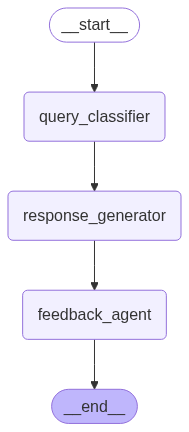

In [ ]:

# ResponseGeneratorAgent
def response_generator_agent(state: FirstLlmAgent):
    print("__ResponseGeneratorAgent__", state)
    prompt = state['prompt']
    ai_msg: AIMessage = llm.invoke(prompt)
    return {"output": ai_msg.content}

# FeedbackAgent
def feedback_agent(state: FeedbackAgent):
    print("__FeedbackAgent__", state)
    # Collect feedback from user
    
    user_feedback = collect_feedback(classify_response, prompt_response:) 
    return {"user_feedback": user_feedback, "session_status": "closed"}


# Create the state graph
builder = StateGraph(state_schema=FirstLlmAgent)
builder.add_node("query_classifier", query_classifier_agent)
builder.add_node("response_generator", response_generator_agent)
builder.add_node("feedback_agent", feedback_agent)

# Add edges to connect nodes
builder.add_edge(START, "query_classifier")
builder.add_edge("query_classifier", "response_generator")
builder.add_edge("response_generator", "feedback_agent")
builder.add_edge("feedback_agent", END)

# Compile the graph
graph: CompiledStateGraph = builder.compile()

# Print and visualize the graph
print(graph)
print(graph.get_graph())
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [35]:
graph.invoke(
    {
        "prompt": "which programming language is mostly used?",
        "output": "",
    }
)
classify_response = 'technical'
prompt_response = 'which programming language is mostly used?'

__QueryClassifierAgent__ {'prompt': 'which programming language is mostly used?', 'output': ''}
__ResponseGeneratorAgent__ {'prompt': 'which programming language is mostly used?', 'output': ''}
__FeedbackAgent__ {}


TypeError: collect_feedback() missing 2 required positional arguments: 'classify_response' and 'prompt_response'